# Setup and load variables

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [64]:
thresh = 10**6 # sample expression threshold
species = "mouse"

In [65]:
# species_s = ['mouse', 'human']

In [66]:
expr = pd.read_csv(f"../../data/prepared/{species}.tsv.gz", sep="\t", header=0, index_col=[0,1])
print(expr.shape)
# rename the first column to "celltype"
idx = list(expr.index.names)
idx[0] = 'celltype'
expr.index.names = idx
expr.T.index.names = ['Gene']
expr.head().iloc[:,:5]

(1313, 31053)


Gene                      Xkr4  Gm1992  Gm37381  Rp1  Sox17
celltype        donor_id                                   
Astro Aqp4_Gfap F003        47       5        0    3      0
                F004        13       1        0    1      0
                F005        40       2        0    0      1
                F006         2       0        0    0      0
                F007         7       0        0    2      0

# First, filter samples

How many samples have fewer than $10^6$ reads?

In [67]:
celltype_sum = expr.sum(axis=1)
celltype_sum

celltype         donor_id
Astro Aqp4_Gfap  F003        1602304
                 F004        1123586
                 F005        1548083
                 F006         203221
                 F007         891005
                              ...   
Vip Sncg         M002         156961
                 M003          57257
                 M004          76019
                 M007          52030
                 M008         171551
Length: 1313, dtype: int64

In [68]:
num_celltypes = (celltype_sum > thresh).sum()
num_celltypes

322

(0.0, 10000000.0)

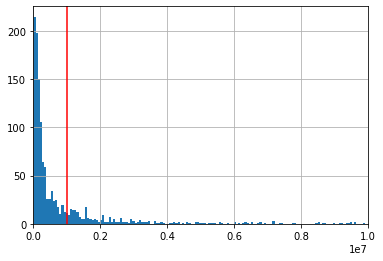

In [69]:
celltype_sum.hist(bins=1000)
plt.axvline(x=thresh, color='red')
plt.xlim([0, 10**7])

In [70]:
expr = expr.iloc[np.where(celltype_sum > thresh)[0]]
expr.shape

(322, 31053)

In [71]:
celltype_sum = celltype_sum[celltype_sum > thresh]
celltype_sum

celltype         donor_id
Astro Aqp4_Gfap  F003        1602304
                 F004        1123586
                 F005        1548083
                 F008        1929613
                 M002        1072272
                              ...   
Sst Hpse         F005        1182742
                 F008        1011971
Sst Pvalb Calb2  F005        1191605
                 F008        1323668
                 M008        1246468
Length: 322, dtype: int64

# Scale to CPM and add pseudocount

In [72]:
# cpm = expr/celltype_sum
cpm = pd.DataFrame((expr.values.T/celltype_sum.values).T, index=expr.index, columns=expr.columns)
cpm = cpm*1e6 + 1
cpm.head().iloc[:,:5]

Gene                           Xkr4    Gm1992  Gm37381       Rp1     Sox17
celltype        donor_id                                                  
Astro Aqp4_Gfap F003      30.332761  4.120506      1.0  2.872304  1.000000
                F004      12.570098  1.890008      1.0  1.890008  1.000000
                F005      26.838408  2.291920      1.0  1.000000  1.645960
                F008       5.145909  2.036477      1.0  1.518239  1.000000
                M002      11.258591  1.000000      1.0  1.000000  1.932599

In [73]:
cpm.sum(axis=1)

celltype         donor_id
Astro Aqp4_Gfap  F003        1031053.0
                 F004        1031053.0
                 F005        1031053.0
                 F008        1031053.0
                 M002        1031053.0
                               ...    
Sst Hpse         F005        1031053.0
                 F008        1031053.0
Sst Pvalb Calb2  F005        1031053.0
                 F008        1031053.0
                 M008        1031053.0
Length: 322, dtype: float64

# Filter genes by CPM

Remove any genes with cumulative $CPM \le 1$ in more than half of the samples.

In [74]:
# remove genes without a count in at least half of our samples
keep_genes = ((cpm <= 1).sum()/num_celltypes) < 0.5
print(f"Keeping {keep_genes.sum()} genes")
keep_genes

Keeping 18570 genes


Gene
Xkr4               True
Gm1992             True
Gm37381            True
Rp1                True
Sox17             False
                  ...  
AC168977.1        False
AC149090.1         True
CAAA01118383.1     True
Vmn2r122          False
CAAA01147332.1     True
Length: 31053, dtype: bool

In [75]:
cpm = cpm.loc[:,keep_genes]
cpm.shape

(322, 18570)

# Log transform

In [76]:
cpm = np.log(cpm)
cpm.head().iloc[:,:5]

Gene                          Xkr4    Gm1992  Gm37381       Rp1    Mrpl15
celltype        donor_id                                                 
Astro Aqp4_Gfap F003      3.412228  1.415976      0.0  1.055114  3.966519
                F004      2.531321  0.636581      0.0  0.636581  4.119371
                F005      3.289834  0.829390      0.0  0.000000  3.819277
                F008      1.638202  0.711221      0.0  0.417551  3.995970
                M002      2.421131  0.000000      0.0  0.000000  4.074501

# Scale so that celltypes sum to $log(10^6)$

In [77]:
cpm = cpm.divide(cpm.sum(axis=1), axis=0)*1e6
cpm.head().iloc[:,:5]

Gene                           Xkr4     Gm1992  Gm37381        Rp1     Mrpl15
celltype        donor_id                                                     
Astro Aqp4_Gfap F003      72.332495  30.015894      0.0  22.366340  84.082359
                F004      55.310282  13.909523      0.0  13.909523  90.009749
                F005      71.144878  17.936119      0.0   0.000000  82.594443
                F008      35.518438  15.420245      0.0   9.053068  86.638046
                M002      52.345083   0.000000      0.0   0.000000  88.091092

# Transpose and write to file

In [78]:
output = f"../../data/prepared/{species}_scaled.tsv.gz"
cpm.to_csv(output, sep="\t")

In [79]:
!zcat {output} | head -n5 | cut -f-5

celltype	donor_id	Xkr4	Gm1992	Gm37381
Astro Aqp4_Gfap	F003	72.33249464403663	30.015893518422168	0.0
Astro Aqp4_Gfap	F004	55.31028161510835	13.909522609314317	0.0
Astro Aqp4_Gfap	F005	71.14487807217267	17.936119357850842	0.0
Astro Aqp4_Gfap	F008	35.518438088791996	15.420244634103147	0.0

gzip: stdout: Broken pipe
